In [1]:
%load_ext autoreload
%autoreload 2

from collect_experiments import display_experiments, display_experiments_helper, BLISSExperiment
from utils import get_eval_stats, analyze_protein_gen_helper_violin
import seaborn as sn

In [2]:
from matplotlib import pyplot as plt
import random 
import numpy as np

def evaluate_ddg_ll_corr_mult(df_list, labels, protein, title='', selected_samples=None):
    for i, df in enumerate(df_list):
        if protein is not None:
            df = df[df['protein_name'] == protein + ".pdb"]
        pre_ddg = df['ddg_eval']
        pre_protgpt = df['loglikelihood']
        if selected_samples is not None and len(pre_ddg) > selected_samples: # type: ignore
            ids = random.sample(range(len(pre_ddg)), selected_samples) # type: ignore
            pre_ddg = np.array(pre_ddg)[ids]
            pre_protgpt = np.array(pre_protgpt)[ids]
        plt.scatter(pre_ddg, pre_protgpt, label=labels[i])
    plt.xlabel('ΔΔG')
    plt.ylabel('Log Likelihood')
    plt.title(title)
    plt.legend(frameon=True)
    plt.show()

In [11]:
import pandas as pd

base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"
a = base_dir + "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10.csv"
b = base_dir + "pretrained_5JRT_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10.csv"

target_protein = '5JRT'
summary_func = np.mean
spec5_r_avg = pd.read_csv(a)
spec5_r_full = pd.read_csv(b)
a_stats = get_eval_stats(spec5_r_avg, target_protein=target_protein, summary_func=summary_func)
b_stats = get_eval_stats(spec5_r_full, target_protein=target_protein, summary_func=summary_func)
print(a_stats)
print(b_stats)

{'ddg': 1.1809658349999999, 'ddg_std': 0.4868636121838456, 'pos_ddg_prop': 1.0, 'scrmsd': 0.8280550003051758, 'scrmsd_std': 0.07223224909895926, 'low_scrmsd_prop': 1.0, 'success_rate': 1.0, 'll': -122.17195129394531, 'll_std': 3.5425382948640878}
{'ddg': 1.0367233580000002, 'ddg_std': 0.5206875242456191, 'pos_ddg_prop': 0.9, 'scrmsd': 0.7705866754055023, 'scrmsd_std': 0.08152354029277277, 'low_scrmsd_prop': 1.0, 'success_rate': 0.9, 'll': -119.99027557373047, 'll_std': 2.164092990167905}


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def display_full_comparison_traj(align_param, N_list, target_protein, summary_func, save_figs=False):
    param_descr = {'ddg' : 'ΔΔG',
                   'll' : 'Log Likelihood',
                   'scrmsd' : 'scRMSD',
                   'success_rate' : 'Success Rate'}
    align_param_descr = {'ddg' : 'ddg', 
                         'll' : 'protgpt', 
                         'scrmsd' : 'scrmsd'}
    summary_func_descr = {np.median : 'Median',
                          np.mean : 'Average'}

    base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"

    # N-dependent datasets
    datasets = {
        "Pretrain-BoN":      ("pretrained_test_{param}_bon_N={N}_specfeedback=0.csv",
                              "pretrained_test_{param}_bon_N={N}_specfeedback=5.csv"),
        "Pretrain-Beam":     ("pretrained_test_{param}_beam_N={N}_specfeedback=0_W=1_stepsperlevel=1.csv",
                              "pretrained_test_{param}_beam_N={N}_specfeedback=5_W=1_stepsperlevel=1.csv"),
        "DRAKES-BoN":        ("drakes_test_{param}_bon_N={N}_specfeedback=0.csv",
                              "drakes_test_{param}_bon_N={N}_specfeedback=5.csv"),
        "DRAKES-Beam":       ("drakes_test_{param}_beam_N={N}_specfeedback=0_W=1_stepsperlevel=1.csv",
                              "drakes_test_{param}_beam_N={N}_specfeedback=5_W=1_stepsperlevel=1.csv")
    }

    # Baselines (single value, not varying with N)
    baselines = {
        "Pretrain": ("pretrained_test.csv",
                     "pretrained_test_{param}_bon_N=1_specfeedback=5.csv"),
        "DRAKES":   ("drakes_test.csv",
                     "drakes_test_{param}_bon_N=1_specfeedback=5.csv")
    }

    # Fix colors so spectral/original share color
    color_map = {
        "Pretrain-BoN": "#75BEFA",
        "DRAKES-BoN":   "#5DC763",
        "Pretrain-Beam": "#FFB347",
        "DRAKES-Beam":  "#FF6961"
    }

    dataset_descr = 'test' if target_protein is None else target_protein.lower()

    for eval_param in param_descr:
        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(9,6))

        # --- Plot N-dependent datasets (with baselines at N=1) ---
        for dataset_name, (before_template, after_template) in datasets.items():
            before_vals, after_vals = [], []
            for N in N_list:
                param = align_param_descr[align_param]

                if N == 1:
                    # Use baseline values instead of BoN files
                    base_name = "Pretrain" if "Pretrain" in dataset_name else "DRAKES"
                    before_file, after_file = baselines[base_name]

                    df_before = pd.read_csv(base_dir + before_file)
                    df_after  = pd.read_csv(base_dir + after_file.format(param=param))

                    before_val = get_eval_stats(
                        df_before, target_protein=target_protein, summary_func=summary_func
                    )[eval_param]
                    after_val  = get_eval_stats(
                        df_after, target_protein=target_protein, summary_func=summary_func
                    )[eval_param]

                else:
                    # Standard BoN files
                    before_path = base_dir + before_template.format(param=param, N=N)
                    after_path  = base_dir + after_template.format(param=param, N=N)

                    df_before = pd.read_csv(before_path)
                    df_after  = pd.read_csv(after_path)

                    before_val = get_eval_stats(
                        df_before, target_protein=target_protein, summary_func=summary_func
                    )[eval_param]
                    after_val  = get_eval_stats(
                        df_after, target_protein=target_protein, summary_func=summary_func
                    )[eval_param]

                before_vals.append(before_val)
                after_vals.append(after_val)

            color = color_map[dataset_name]
            ax.set_xticks([1]+list(range(25, max(N_list)+1, 25)))
            ax.plot(N_list, before_vals, marker="o", color=color,
                    label=f"{dataset_name} - Original")
            ax.plot(N_list, after_vals, marker="s", linestyle="--", color=color,
                    label=f"{dataset_name} - Spectral (K=5)")

        # --- Labels/titles ---
        protein_descr = "" if target_protein is None else target_protein + " "
        func_txt = f'{summary_func_descr[summary_func]} ' if eval_param != 'success_rate' else ''

        ax.set_ylabel(f"{func_txt}{param_descr[eval_param]}", fontsize=12, weight='bold')
        ax.set_xlabel("N", fontsize=12, weight='bold')
        ax.set_title(f"Spectral Enhanced {protein_descr}{param_descr[align_param]} Alignment",
                     fontsize=15, weight="bold")

        ax.legend(frameon=True, fontsize=10, loc="best")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        plt.tight_layout()
        if save_figs:
            out_path = f'/home/shai/BLISS_Experiments/DRAKES/figures/scaling_{dataset_descr}_{align_param}_{eval_param}_full.png'
            plt.savefig(out_path)
        plt.show()

In [ ]:
align_param = 'ddg'
N_list = [1, 10, 50, 100, 250]
target_protein = None
summary_func = np.median

# display_full_comparison(align_param, N, target_protein, summary_func, save_figs=False)
display_full_comparison_traj(align_param, N_list, target_protein, summary_func, save_figs=True)

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def display_full_comparison(align_param, N, target_protein, summary_func, save_figs=False):
    param_descr = {'ddg' : 'ΔΔG',
                        'll' : 'Log Likelihood',
                        'scrmsd' : 'scRMSD',
                        'success_rate' : 'Success Rate'}
    align_param_descr = {'ddg' : 'ddg', 
                         'll' : 'protgpt', 
                         'scrmsd' : 'scrmsd'}
    summary_func_descr = {np.median : 'Median',
                        np.mean : 'Average'}
    
    # Assume get_eval_stats is defined elsewhere
    base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"
    pretrained_path = base_dir + "pretrained_test.csv"
    #pretrained_spectral_path = base_dir + f"pretrained_test_{align_param_descr[align_param]}_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10.csv"
    pretrained_spectral_path = base_dir + "pretrained_test_protgpt_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10.csv"
    # bon_path = base_dir + f"pretrained_test_{align_param_descr[align_param]}_bon_N={N}_specfeedback=0.csv"
    # beam_path = base_dir + f"pretrained_test_{align_param_descr[align_param]}_beam_N={N}_specfeedback=0_W=1_stepsperlevel=1.csv"
    # bon_spectral_path = base_dir + f"pretrained_test_{align_param_descr[align_param]}_bon_N={N}_specfeedback=5.csv"
    # beam_spectral_path = base_dir + f"pretrained_test_{align_param_descr[align_param]}_beam_N={N}_specfeedback=5_W=1_stepsperlevel=1.csv"

    # drakes_path = base_dir + "drakes_test.csv"
    # drakes_spectral_path = base_dir + f"drakes_test_{align_param_descr[align_param]}_bon_N=1_specfeedback=5.csv"
    # drakes_bon_path = base_dir + f"drakes_test_{align_param_descr[align_param]}_bon_N={N}_specfeedback=0.csv"
    # drakes_beam_path = base_dir + f"drakes_test_{align_param_descr[align_param]}_beam_N={N}_specfeedback=0_W=1_stepsperlevel=1.csv"
    # drakes_bon_spectral_path = base_dir + f"drakes_test_{align_param_descr[align_param]}_bon_N={N}_specfeedback=5.csv"
    # drakes_beam_spectral_path = base_dir + f"drakes_test_{align_param_descr[align_param]}_beam_N={N}_specfeedback=5_W=1_stepsperlevel=1.csv"

    datasets = {
        "Pretrain": {"before": pretrained_path, "after": pretrained_spectral_path},
        # "Pretrain-BoN": {"before": bon_path, "after": bon_spectral_path},
        # "Pretrain-Beam": {"before": beam_path, "after": beam_spectral_path},
        # "DRAKES": {"before": drakes_path, "after": drakes_spectral_path},
        # "DRAKES-BoN": {"before": drakes_bon_path, "after": drakes_bon_spectral_path},
        # "DRAKES-Beam": {"before": drakes_beam_path, "after": drakes_beam_spectral_path}
    }

    base_out_path = f"/home/shai/BLISS_Experiments/DRAKES/figures/N{N}"

    dataset_descr = 'test' if target_protein is None else target_protein.lower()

    for eval_param in param_descr:
        before_stats, after_stats = [], []
        for name, paths in datasets.items():
            df_before = pd.read_csv(paths["before"])
            df_after  = pd.read_csv(paths["after"])
            before_stats.append(get_eval_stats(df_before, target_protein=target_protein, summary_func=summary_func)[eval_param])
            after_stats.append(get_eval_stats(df_after, target_protein=target_protein, summary_func=summary_func)[eval_param])

        categories = list(datasets.keys())
        x = np.arange(len(categories))
        width = 0.35

        plt.style.use("seaborn-v0_8-whitegrid")
        fig, ax = plt.subplots(figsize=(9,6))

        # Bars
        bars_before = ax.bar(x - width/2, before_stats, width, label="Original", color="#4C78A8", alpha=0.9)
        bars_after  = ax.bar(x + width/2, after_stats, width, label="Spectral (K=5)", color="#72B7B2", alpha=0.9)

        # Add values inside bars (white text)
        for bar_before, bar_after in zip(bars_before, bars_after):
            height_before = bar_before.get_height()
            height_after = bar_after.get_height()
            # Before
            ax.text(bar_before.get_x() + bar_before.get_width()/2, height_before/2,
                    f"{height_before:.2f}", ha="center", va="center",
                    fontsize=9, color="white", weight="bold")
            # After
            ax.text(bar_after.get_x() + bar_after.get_width()/2, height_after/2,
                    f"{height_after:.2f}", ha="center", va="center",
                    fontsize=9, color="white", weight="bold")

        # Improvement labels (+/-)
        all_stats = np.array(before_stats + after_stats, dtype=float)
        max_abs = np.max(np.abs(all_stats)) if all_stats.size else 1.0
        if max_abs == 0:
            max_abs = 1.0
        offset = 0.02 * max_abs
        extra_margin = 0#0.02 * max_abs
        label_positions = []

        for bar_before, bar_after in zip(bars_before, bars_after):
            height_before = bar_before.get_height()
            height_after = bar_after.get_height()

            diff = height_after - height_before
            sign_symbol = "+" if diff >= 0 else "-"
            diff = abs(diff)

            if height_after >= 0:
                y_pos = height_after + offset
                va = "bottom"
            else:
                y_pos = height_after - offset
                va = "top"

            ax.text(bar_after.get_x() + bar_after.get_width()/2, y_pos,
                    f"{sign_symbol}{diff:.2f}", ha="center", va=va,
                    fontsize=10, weight="bold", color="#333", clip_on=False)

            label_positions.append(y_pos)

        # Expand y-limits so labels are visible
        if label_positions:
            ymin, ymax = ax.get_ylim()
            ymin_new = min(ymin, min(label_positions) - extra_margin)
            ymax_new = max(ymax, max(label_positions) + extra_margin)
            if (ymin_new, ymax_new) != (ymin, ymax):
                ax.set_ylim(ymin_new, ymax_new)

        # Labels/titles
        if target_protein is not None:
            protein_descr = target_protein + " "
        else:
            protein_descr = ""

        if eval_param != 'success_rate':
            func_txt = f'{summary_func_descr[summary_func]} '
        else:
            func_txt = ''

        ax.set_ylabel(f"{func_txt}{param_descr[eval_param]}", fontsize=12, weight='bold')
        ax.set_xlabel(f"Alignment Method (N={N})", fontsize=12, weight='bold')
        ax.set_title(f"Spectral Enhanced {protein_descr}{param_descr[align_param]} Alignment",
                     fontsize=15, weight="bold")
        ax.set_xticks(x)
        ax.set_xticklabels(categories, fontsize=11)
        ax.legend(frameon=True, fontsize=11, loc="upper left")

        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.grid(axis="y", linestyle="--", alpha=0.6)

        plt.tight_layout()
        if save_figs:
            out_path = f'{base_out_path}/{dataset_descr}_n{N}_{align_param}_align_{eval_param}_eval.png'
            plt.savefig(out_path)
        plt.show()
        
    data = [pd.read_csv(datasets[x][y]) for x in datasets for y in ['before', 'after']]
    labels = [x + y for x in datasets for y in ['', '-Spectral']]
    colors = sn.color_palette("Set2", len(data))
    protein_output = target_protein + " " if target_protein is not None else ""

    ddg_outpath = f'{base_out_path}/{dataset_descr}_n{N}_{align_param}_align_ddg_eval_distribution.png' if save_figs else None
    ll_outpath = f'{base_out_path}/{dataset_descr}_n{N}_{align_param}_align_ll_eval_distribution.png' if save_figs else None
    scrmsd_outpath = f'{base_out_path}/{dataset_descr}_n{N}_{align_param}_align_scrmsd_eval_distribution.png' if save_figs else None
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'ddg_eval', y_label='Predicted ΔΔG', legend_pos='right', title=f'Sampling vs DRAKES Alignment {protein_output}ΔΔG Evaluation (N={N}, K=5)', out_path=ddg_outpath)
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'loglikelihood', y_label='Log Likelihood', legend_pos='right', title=f'Sampling vs DRAKES Alignment {protein_output}Log Likelihood Evaluation (N={N}, K=5)', out_path=ll_outpath)
    analyze_protein_gen_helper_violin(target_protein, data, labels, colors, 'scrmsd', y_label='scRMSD', legend_pos='right', title=f'Sampling vs DRAKES Alignment {protein_output}scRMSD Evaluation (N={N}, K=5)', out_path=scrmsd_outpath)

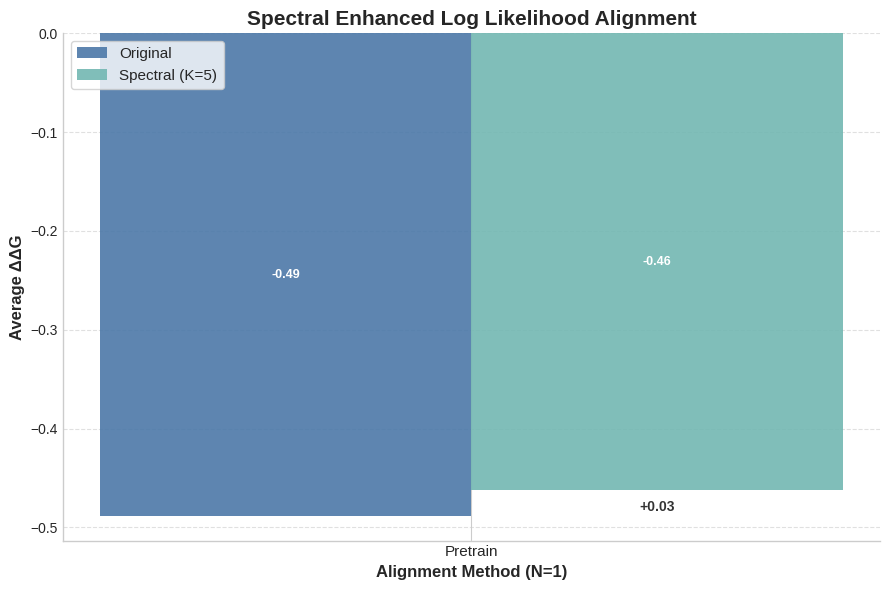

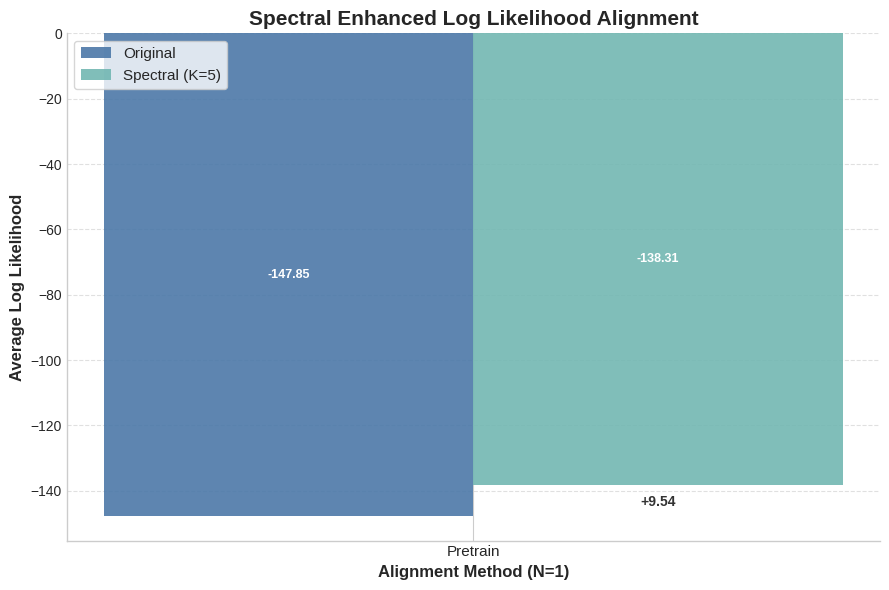

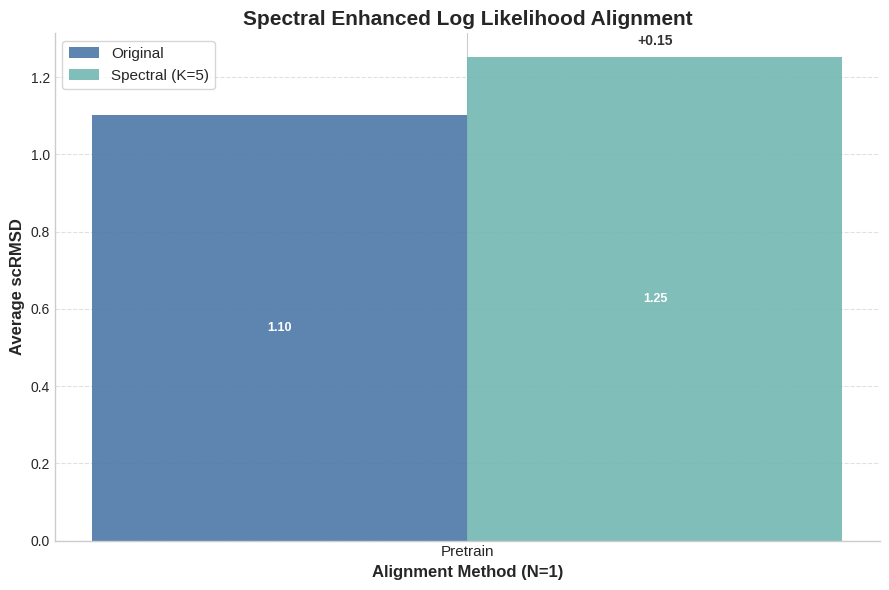

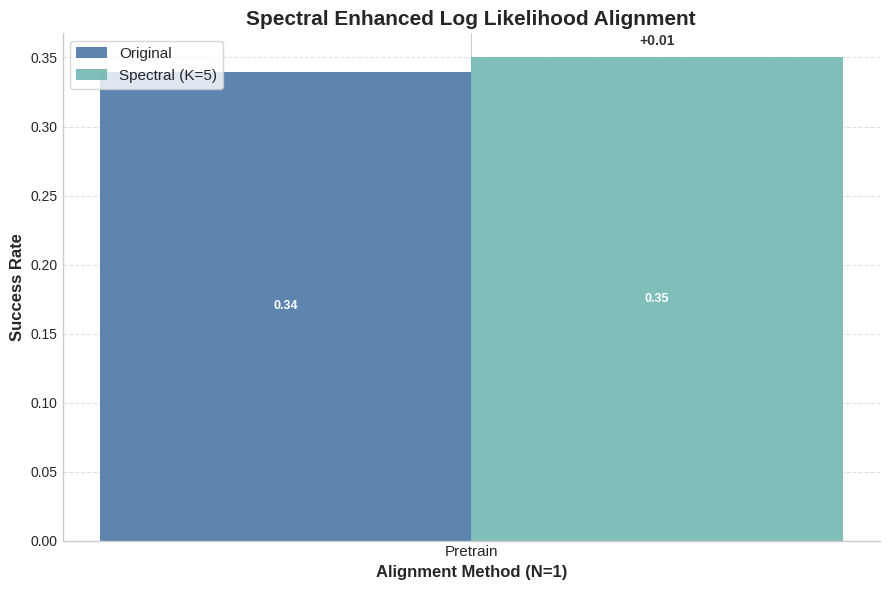

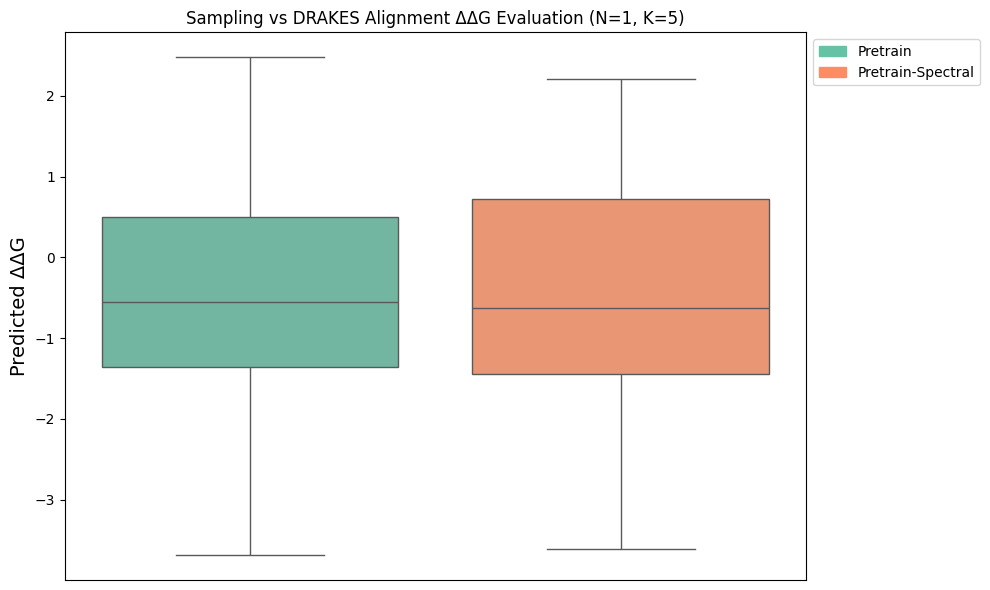

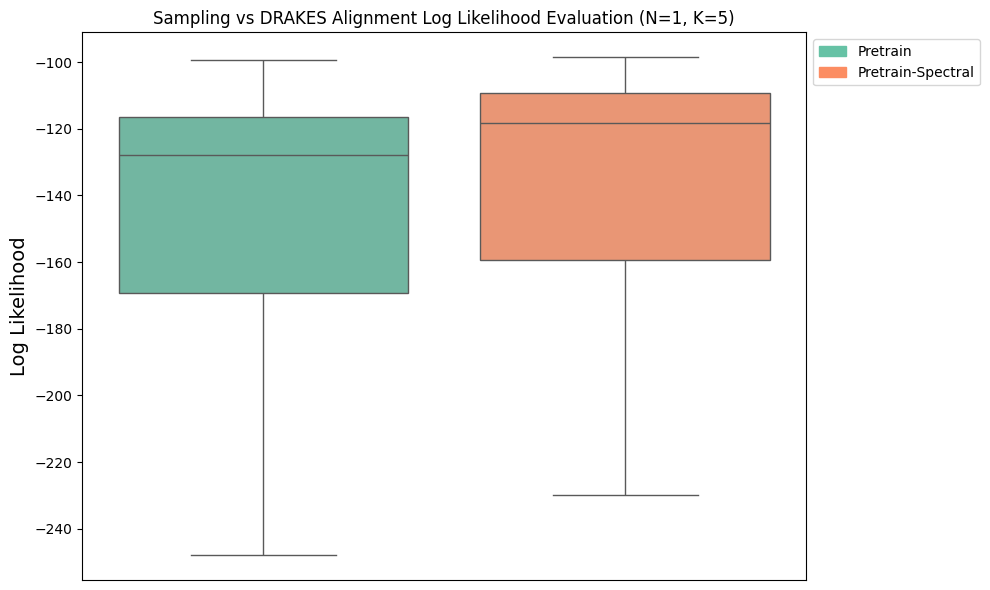

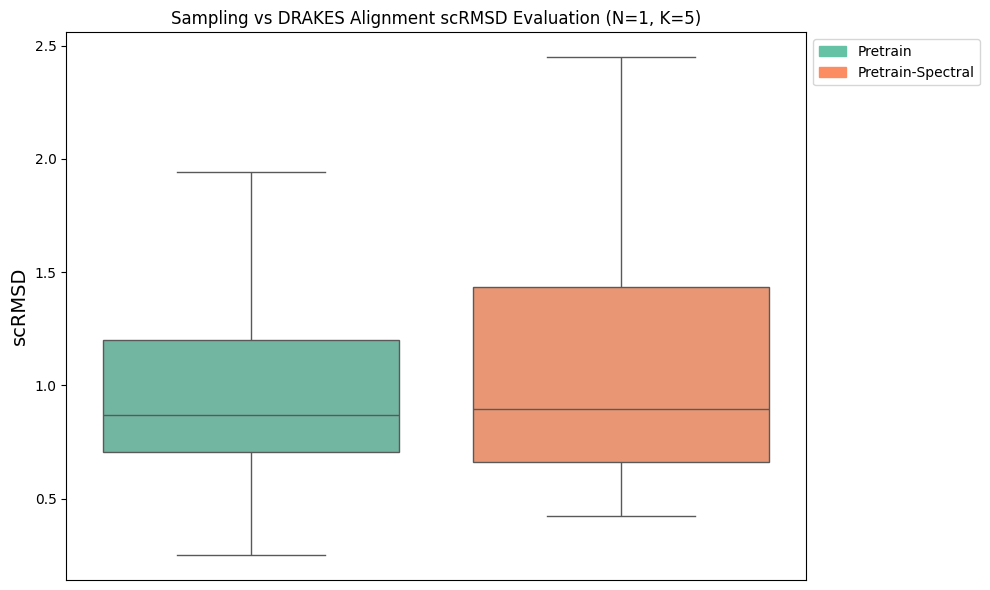

In [22]:
align_param = 'll'
target_protein = None
summary_func = np.mean

display_full_comparison(align_param, 1, target_protein, summary_func, save_figs=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_ddg_spectral_iterations(target_protein=None, save_figs=False):
    """
    Plot ΔΔG values across spectral iterations (0 to 5)
    for pretrained-BoN with N=1.
    """
    base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"

    summary_func = np.median
    param_descr = {'ddg': 'ΔΔG'}
    summary_func_descr = {np.median: 'Median', np.mean: 'Average'}

    # Build paths for spectral iterations
    paths = {
        k: base_dir + f"pretrained_test_ddg_bon_N=1_specfeedback={k}.csv"
        for k in range(6)
    }

    stats = []
    for k, path in paths.items():
        df = pd.read_csv(path)
        val = get_eval_stats(df, target_protein=target_protein, summary_func=summary_func)["ddg"]
        stats.append(val)

    # Plot
    plt.style.use("seaborn-v0_8-whitegrid")
    fig, ax = plt.subplots(figsize=(8, 5))

    x = np.arange(len(stats))
    bars = ax.bar(x, stats, color="#72B7B2", alpha=0.9, width=0.6)

    # Values inside bars
    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h/2,
                f"{h:.2f}", ha="center", va="center",
                fontsize=9, color="white", weight="bold")

    # Labels
    if target_protein is not None:
        protein_descr = target_protein + " "
    else:
        protein_descr = ""

    func_txt = f'{summary_func_descr[summary_func]} '

    ax.set_ylabel(f"{func_txt}{param_descr['ddg']}", fontsize=12, weight="bold")
    ax.set_xlabel("Spectral Iteration (K)", fontsize=12, weight="bold")
    ax.set_title(f"{protein_descr}ΔΔG Spectral Distribution (Pretrained)",
                 fontsize=15, weight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels([f"K={k}" for k in range(6)], fontsize=11)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(axis="y", linestyle="--", alpha=0.6)

    plt.tight_layout()

    if save_figs:
        dataset_descr = 'test' if target_protein is None else target_protein.lower()
        out_path = f"{base_dir}/../figures/N1/{dataset_descr}_pretrain_bon_ddg_spectral_iters.png"
        plt.savefig(out_path)

    plt.show()

plot_ddg_spectral_iterations(target_protein='1F0M')

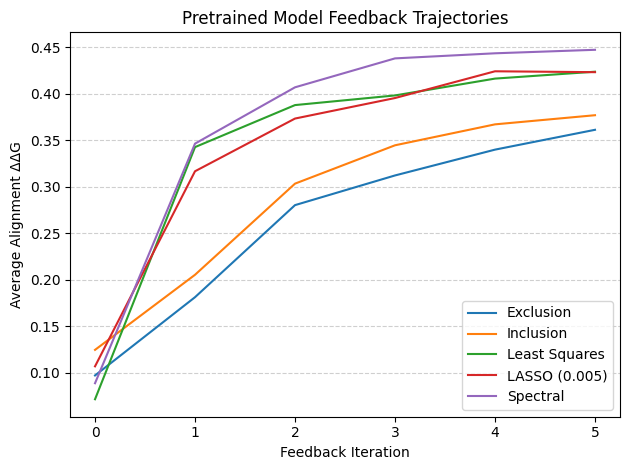

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ast

def eval_ddg_spectral_trajectories(exp_names, exp_labels, target_protein, title, align_mode, summary_func = np.median):
    base_dir = "/home/shai/BLISS_Experiments/DRAKES/DRAKES/drakes_protein/fmif/eval_results/test/"

    param_descr = {'ddg': 'ΔΔG',
                   'scrmsd': 'scRMSD',
                   'll': 'Log Likelihood'}
    data_scaling = -1 if align_mode == 'scrmsd' else 1

    for exp_name, exp_label in zip(exp_names, exp_labels):
        # Build paths for spectral iterations
        path = base_dir + exp_name + ".csv"
        df = pd.read_csv(path)
        if target_protein is not None:
            df = df[df['protein_name'] == target_protein + '.pdb']
        trajectories = [ast.literal_eval(s) for s in df['spec_trajectory']]
        max_len = max(len(t) for t in trajectories)
        trajectories = [t + [t[-1]] * (max_len - len(t)) for t in trajectories]
        trajectories = np.array(trajectories) * data_scaling
        avg_trajectory = summary_func(trajectories, axis=0)

        plt.plot(list(range(0, len(avg_trajectory))), avg_trajectory, label=exp_label)

    target_protein_label = "" if target_protein is None else target_protein + " " # type: ignore

    plt.xticks(list(range(0, len(avg_trajectory)))) # type: ignore
    plt.xlabel("Feedback Iteration")
    plt.ylabel(f"Average Alignment {param_descr[align_mode]}")
    plt.title(f"{target_protein_label}{title}")
    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

target_protein = None
exp1 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=exclusion_maxspecorder=10"
exp2 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=inclusion_maxspecorder=10"
exp3 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=lasso_maxspecorder=10_lassolambda=0.0"
exp4 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=lasso_maxspecorder=10_lassolambda=0.005"
exp5 = "pretrained_test_ddg_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10"
exp_names = [exp1, exp2, exp3, exp4, exp5]
exp_labels = ['Exclusion', 'Inclusion', 'Least Squares', 'LASSO (0.005)', 'Spectral']
summary_func = np.mean
align_mode = 'ddg'
eval_ddg_spectral_trajectories(exp_names=exp_names, exp_labels=exp_labels, target_protein=target_protein, title="Pretrained Model Feedback Trajectories", align_mode=align_mode, summary_func=summary_func)


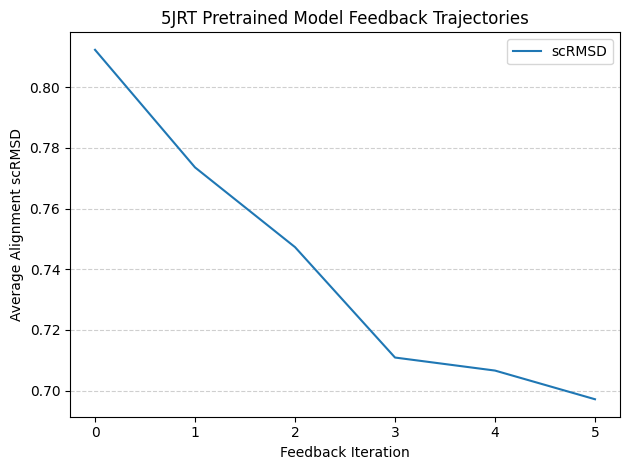

In [25]:
target_protein = '5JRT'
exp_scrmsd = "pretrained_5JRT_scrmsd_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10"
exp_names = [exp_scrmsd]
exp_labels = ['scRMSD']
summary_func = np.mean
align_mode = 'scrmsd'
eval_ddg_spectral_trajectories(exp_names=exp_names, exp_labels=exp_labels, target_protein=target_protein, title="Pretrained Model Feedback Trajectories", align_mode=align_mode, summary_func=summary_func)


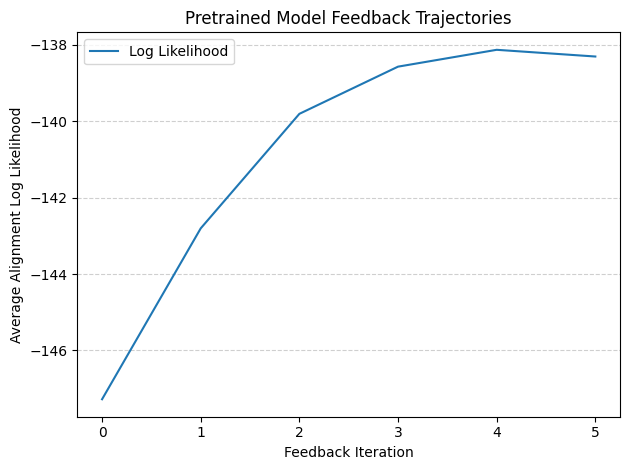

In [26]:
target_protein = None
exp_scrmsd = "pretrained_test_protgpt_bon_N=1_feedbacksteps=5_feedbackmethod=spectral_maxspecorder=10"
exp_names = [exp_scrmsd]
exp_labels = ['Log Likelihood']
summary_func = np.mean
align_mode = 'll'
eval_ddg_spectral_trajectories(exp_names=exp_names, exp_labels=exp_labels, target_protein=target_protein, title="Pretrained Model Feedback Trajectories", align_mode=align_mode, summary_func=summary_func)
